In [1]:
# @title Load the imports

import io
import keras
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd
import plotly.express as px

# The following lines adjust the granularity of reporting.
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

print("Ran the import statements.")

2025-01-07 13:19:16.853869: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-07 13:19:16.855576: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-07 13:19:16.868201: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-07 13:19:16.888236: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736255956.912434   61408 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736255956.91

Ran the import statements.


In [2]:
# @title Load the dataset
rice_dataset_raw = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/Rice_Cammeo_Osmancik.csv")

In [3]:
# @title
# Read and provide statistics on the dataset.
rice_dataset = rice_dataset_raw[[
    'Area',
    'Perimeter',
    'Major_Axis_Length',
    'Minor_Axis_Length',
    'Eccentricity',
    'Convex_Area',
    'Extent',
    'Class',
]]

rice_dataset.describe()

,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Eccentricity,Convex_Area,Extent
count,3810.0,3810.0,3810.0,3810.0,3810.0,3810.0,3810.0
mean,12667.7,454.2,188.8,86.3,0.9,12952.5,0.7
std,1732.4,35.6,17.4,5.7,0.0,1777.0,0.1
min,7551.0,359.1,145.3,59.5,0.8,7723.0,0.5
25%,11370.5,426.1,174.4,82.7,0.9,11626.2,0.6
50%,12421.5,448.9,185.8,86.4,0.9,12706.5,0.6
75%,13950.0,483.7,203.6,90.1,0.9,14284.0,0.7
max,18913.0,548.4,239.0,107.5,0.9,19099.0,0.9


From the summary statistics above, answer the following questions:
- What are the min and max lengths (major axis length, given in pixels) of the rice grains?
- What is the range of areas between the smallest and largest rice grains?
- How many standard deviations (std) is the largest rice grain's perimeter from the mean?

In [4]:
# @title Solutions (run the cell to get the answers)

print(
    f'The shortest grain is {rice_dataset.Major_Axis_Length.min():.1f}px long,'
    f' while the longest is {rice_dataset.Major_Axis_Length.max():.1f}px.'
)
print(
    f'The smallest rice grain has an area of {rice_dataset.Area.min()}px, while'
    f' the largest has an area of {rice_dataset.Area.max()}px.'
)
print(
    'The largest rice grain, with a perimeter of'
    f' {rice_dataset.Perimeter.max():.1f}px, is'
    f' ~{(rice_dataset.Perimeter.max() - rice_dataset.Perimeter.mean())/rice_dataset.Perimeter.std():.1f} standard'
    f' deviations ({rice_dataset.Perimeter.std():.1f}) from the mean'
    f' ({rice_dataset.Perimeter.mean():.1f}px).'
)
print(
    f'This is calculated as: ({rice_dataset.Perimeter.max():.1f} -'
    f' {rice_dataset.Perimeter.mean():.1f})/{rice_dataset.Perimeter.std():.1f} ='
    f' {(rice_dataset.Perimeter.max() - rice_dataset.Perimeter.mean())/rice_dataset.Perimeter.std():.1f}'
)

The shortest grain is 145.3px long, while the longest is 239.0px.
The smallest rice grain has an area of 7551px, while the largest has an area of 18913px.
The largest rice grain, with a perimeter of 548.4px, is ~2.6 standard deviations (35.6) from the mean (454.2px).
This is calculated as: (548.4 - 454.2)/35.6 = 2.6


In [5]:
# Create five 2D plots of the features against each other, color-coded by class.
n=0
for x_axis_data, y_axis_data in [
    ('Area', 'Eccentricity'),
    ('Convex_Area', 'Perimeter'),
    ('Major_Axis_Length', 'Minor_Axis_Length'),
    ('Perimeter', 'Extent'),
    ('Eccentricity', 'Major_Axis_Length'),
]:
  px.scatter(rice_dataset, x=x_axis_data, y=y_axis_data, color='Class').write_html(f'plot{n}.html')
  n=n+1

In [6]:
# @title One possible solution

# Plot major and minor axis length and eccentricity, with observations
# color-coded by class.
px.scatter_3d(
    rice_dataset,
    x='Eccentricity',
    y='Area',
    z='Major_Axis_Length',
    color='Class',
).write_html('plot_3D.html')

In [7]:
# Calculate the Z-scores of each numerical column in the raw data and write
# them into a new DataFrame named df_norm.

feature_mean = rice_dataset.mean(numeric_only=True)
feature_std  = rice_dataset.std(numeric_only=True)
numerical_features = rice_dataset.select_dtypes('number').columns
normalized_dataset = (rice_dataset[numerical_features] - feature_mean) / feature_std

# Copy the class to the new dataframe
normalized_dataset['Class'] = rice_dataset['Class']

# Examine some of the values of the normalized training set. Notice that most
# Z-scores fall between -2 and +2.
normalized_dataset.head()

,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Eccentricity,Convex_Area,Extent,Class
0,1.5,2.0,2.3,-0.2,2.0,1.5,-1.2,Cammeo
1,1.1,1.1,1.0,0.9,0.4,1.2,-0.6,Cammeo
2,1.1,1.3,1.5,0.3,1.2,1.1,0.4,Cammeo
3,0.3,0.1,0.3,0.2,0.2,0.2,-0.3,Cammeo
4,1.2,1.5,1.3,0.5,1.0,1.3,-0.2,Cammeo


In [8]:
# Set the random seeds:
#
# To make experiments reproducible, we set the seed of the random number generators. 
# This means that the order in which the data is shuffled, the values of the random 
# weight initializations, etc, will all be the same each time the colab is run.

keras.utils.set_random_seed(42)

In [9]:
# Create a column setting the Cammeo label to '1' and the Osmancik label to '0'
# then show 10 randomly selected rows.
normalized_dataset['Class_Bool'] = (
    # Returns true if class is Cammeo, and false if class is Osmancik
    normalized_dataset['Class'] == 'Cammeo'
).astype(int)

normalized_dataset.sample(10)

,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Eccentricity,Convex_Area,Extent,Class,Class_Bool
1011,-0.1,0.1,-0.1,0.2,-0.1,-0.0,-1.0,Cammeo,1
3185,-0.1,-0.5,-0.5,0.4,-0.8,-0.2,-0.3,Osmancik,0
3698,0.1,-0.1,-0.4,0.9,-1.1,0.1,-0.2,Osmancik,0
897,0.2,0.5,0.8,-0.5,1.2,0.2,1.5,Cammeo,1
3245,-1.3,-1.3,-0.9,-1.6,0.5,-1.4,-1.1,Osmancik,0
478,0.2,0.2,0.4,-0.0,0.5,0.2,1.7,Cammeo,1
1731,-0.4,-0.8,-0.8,0.3,-1.0,-0.5,-0.4,Osmancik,0
1025,0.6,0.7,0.6,0.3,0.5,0.6,-0.5,Cammeo,1
429,1.2,1.2,1.4,0.6,1.0,1.2,1.8,Cammeo,1
1330,-0.4,-0.0,0.4,-1.3,1.4,-0.5,-0.1,Cammeo,1


In [10]:
# Create indices at the 80th and 90th percentiles
number_semples = len(normalized_dataset)
index_80th = round(number_semples * 0.8)
index_90th = index_80th + round(number_semples * 0.1)

# Randomize order and split into train, validation, and test with a .8, .1, .1 split
shufled_dataset = normalized_dataset.sample(frac=1, random_state=100)
train_data = shufled_dataset.iloc[0:index_80th]
validation_data = shufled_dataset.iloc[index_80th:index_90th]
test_data = shufled_dataset.iloc[index_90th:]

# Show the first five rows of the last split
test_data.head()

,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Eccentricity,Convex_Area,Extent,Class,Class_Bool
2405,-0.4,-0.7,-0.8,0.3,-1.1,-0.4,0.3,Osmancik,0
3062,-0.2,-0.0,0.2,-0.7,0.8,-0.2,1.6,Osmancik,0
1155,1.4,1.2,1.1,1.2,0.3,1.3,0.7,Cammeo,1
660,1.2,1.0,0.8,1.3,-0.0,1.2,-0.6,Cammeo,1
2451,-1.2,-1.2,-1.4,-0.3,-1.5,-1.1,0.1,Osmancik,0


In [18]:
label_columns = ['Class', 'Class_Bool']

train_features = train_data.drop(columns=label_columns)
train_labels = train_data['Class_Bool'].to_numpy()
validation_features = validation_data.drop(columns=label_columns)
validation_labels = validation_data['Class_Bool'].to_numpy()
test_features = test_data.drop(columns=label_columns)
test_labels = test_data['Class_Bool'].to_numpy()


### Train model

In [19]:
# Name of the features we'll train our model on.
input_features = [
    'Eccentricity',
    'Major_Axis_Length',
    'Area',
]

In [24]:
# @title Define the functions that create and train a model.

import dataclasses

@dataclasses.dataclass()
class ExperimentSettings:
    """List the hyperparameters and input features used to train a model"""
    
    learning_rate : float
    number_epochs : int
    batch_size : int
    classification_threshold : float
    input_features : list[str]
    
@dataclasses.dataclass()
class Experiment:
    """Stores the settings used for a training run and the resulting model."""
  
    name: str
    settings: ExperimentSettings
    model: keras.Model
    epochs: np.ndarray
    metrics_history: keras.callbacks.History

    def get_final_metric_value(self, metric_name: str) -> float:
        """Gets the final value of the given metric for this experiment."""
        if metric_name not in self.metrics_history:
            raise ValueError(
                f'Unknown metric {metric_name}: available metrics are'
                f' {list(self.metrics_history.columns)}'
            )
        return self.metrics_history[metric_name].iloc[-1]

def create_model(
    settings: ExperimentSettings,
    metrics: list[keras.metrics.Metric],
) -> keras.Model:
    """Create and compile a simple classification model."""
    model_inputs = [
        keras.Input(name=feature, shape=(1,))
        for feature in settings.input_features
    ]
    # Use a Concatenate layer to assemble the different inputs into a single
    # tensor which will be given as input to the Dense layer.
    # For example: [input_1[0][0], input_2[0][0]]
    concatenated_inputs = keras.layers.Concatenate()(model_inputs)
    dense = keras.layers.Dense(
        units=1, input_shape=(1,), name='dense_layer', activation=keras.activations.sigmoid
    )
    model_output = dense(concatenated_inputs)
    model = keras.Model(inputs=model_inputs, outputs=model_output)
    # Call the compile method to transform the layers into a model that
    # Keras can execute.  Notice that we're using a different loss
    # function for classification than for regression.
    model.compile(
        optimizer=keras.optimizers.RMSprop(
            settings.learning_rate
        ),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=metrics,
    )
    return model
    
def train_model(
    experiment_name: str,
    model: keras.Model,
    dataset: pd.DataFrame,
    labels: np.ndarray,
    settings: ExperimentSettings,
) -> Experiment:
    """Feed a dataset into the model in order to train it."""

    # The x parameter of keras.Model.fit can be a list of arrays, where
    # each array contains the data for one feature.
    features = {
        feature_name: np.array(dataset[feature_name])
        for feature_name in settings.input_features
    }
    
    history = model.fit(
        x=features,
        y=labels,
        batch_size=settings.batch_size,
        epochs=settings.number_epochs,
    )
    
    return Experiment(
        name=experiment_name,
        settings=settings,
        model=model,
        epochs=history.epoch,
        metrics_history=pd.DataFrame(history.history),
    )
    

In [25]:
# @title Define the plotting function.
def plot_experiment_metrics(experiment: Experiment, metrics: list[str]):
    """Plot a curve of one or more metrics for different epochs."""
    plt.figure(figsize=(12, 8))

    for metric in metrics:
        plt.plot(
            experiment.epochs, experiment.metrics_history[metric], label=metric
        )

    plt.xlabel("Epoch")
    plt.ylabel("Metric value")
    plt.grid()
    plt.legend()
    
print("Defined the plot_curve function.")

Defined the plot_curve function.


2025-01-07 15:39:10.397851: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/vitya/repos/ml/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6879 - auc: 0.8524 - loss: 0.5124 - precision: 0.5897 - recall: 0.9565   
Epoch 2/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7115 - auc: 0.8697 - loss: 0.4899 - precision: 0.6103 - recall: 0.9537 
Epoch 3/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7330 - auc: 0.8822 - loss: 0.4712 - precision: 0.6293 - recall: 0.9575 
Epoch 4/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7512 - auc: 0.8931 - loss: 0.4537 - precision: 0.6473 - recall: 0.9551 
Epoch 5/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - accuracy: 0.7643 - auc: 0.9022 - loss: 0.4373 - precision: 0.6606 - recall: 0.9553
Epoch 6/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7727 - auc: 0.9105 - loss: 0.4220 - precision: 0.6698 - recall: 0.9533 
Epoch 7/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7829 - auc: 0.9176 - loss: 0.4076 - precision: 0.6812 - recall: 0.9521 
Epoch 8/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/s

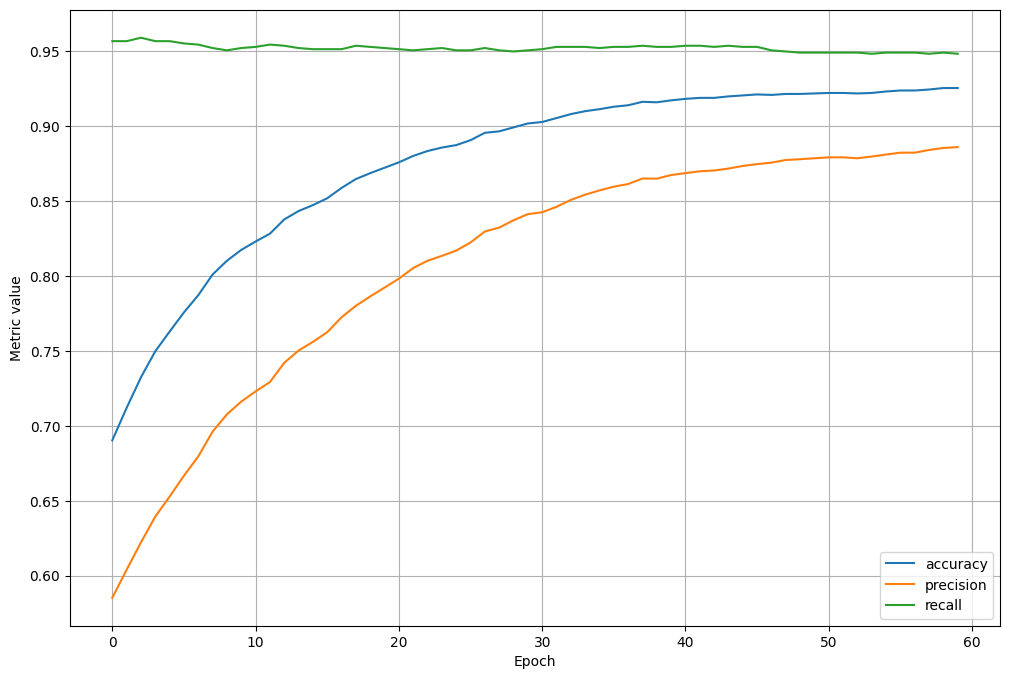

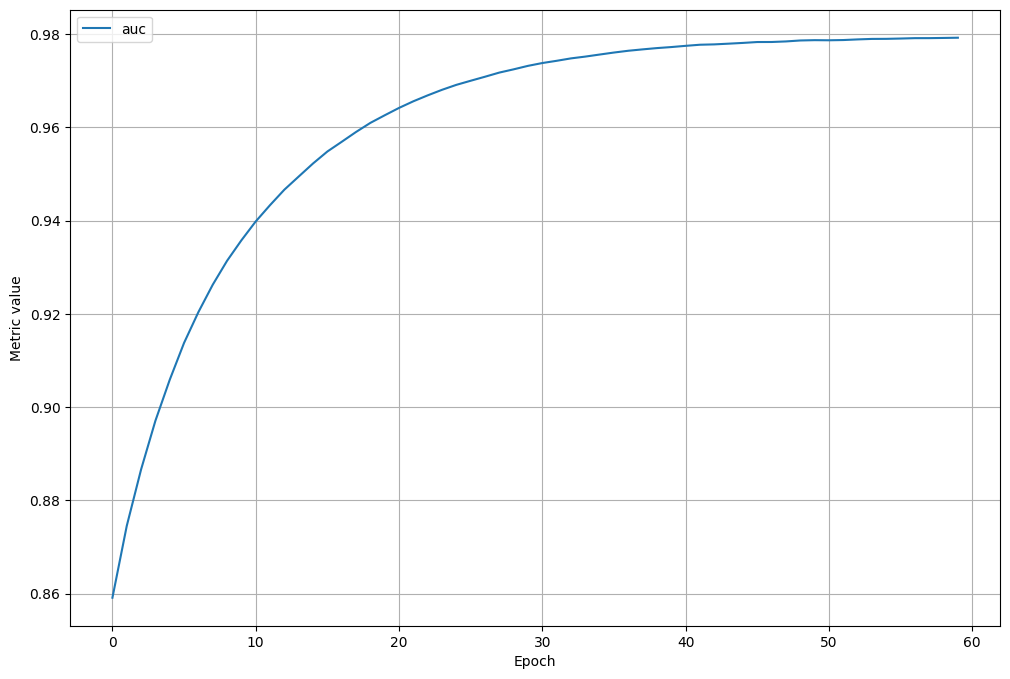

In [26]:
# Let's define our first experiment settings.
settings = ExperimentSettings(
    learning_rate=0.001,
    number_epochs=60,
    batch_size=100,
    classification_threshold=0.35,
    input_features=input_features,
)

metrics = [
    keras.metrics.BinaryAccuracy(
        name='accuracy', threshold=settings.classification_threshold
    ),
    keras.metrics.Precision(
        name='precision', thresholds=settings.classification_threshold
    ),
    keras.metrics.Recall(
        name='recall', thresholds=settings.classification_threshold
    ),
    keras.metrics.AUC(num_thresholds=100, name='auc'),
]

# Establish the model's topography.
model = create_model(settings, metrics)

# Train the model on the training set.
experiment = train_model(
    'baseline', model, train_features, train_labels, settings
)

# Plot metrics vs. epochs
plot_experiment_metrics(experiment, ['accuracy', 'precision', 'recall'])
plot_experiment_metrics(experiment, ['auc'])

In [27]:
def evaluate_experiment(
    experiment: Experiment, test_dataset: pd.DataFrame, test_labels: np.array
) -> dict[str, float]:
  features = {
      feature_name: np.array(test_dataset[feature_name])
      for feature_name in experiment.settings.input_features
  }
  return experiment.model.evaluate(
      x=features,
      y=test_labels,
      batch_size=settings.batch_size,
      verbose=0, # Hide progress bar
      return_dict=True,
  )


def compare_train_test(experiment: Experiment, test_metrics: dict[str, float]):
  print('Comparing metrics between train and test:')
  for metric, test_value in test_metrics.items():
    print('------')
    print(f'Train {metric}: {experiment.get_final_metric_value(metric):.4f}')
    print(f'Test {metric}:  {test_value:.4f}')


# Evaluate test metrics
test_metrics = evaluate_experiment(experiment, test_features, test_labels)
compare_train_test(experiment, test_metrics)

Comparing metrics between train and test:
------
Train accuracy: 0.9252
Test accuracy:  0.9081
------
Train auc: 0.9793
Test auc:  0.9752
------
Train loss: 0.1844
Test loss:  0.1959
------
Train precision: 0.8858
Test precision:  0.8545
------
Train recall: 0.9481
Test recall:  0.9276


In [28]:
#@title Solution
# Features used to train the model on.
# Specify all features.
all_input_features = [
  'Eccentricity',
  'Major_Axis_Length',
  'Minor_Axis_Length',
  'Area',
  'Convex_Area',
  'Perimeter',
  'Extent',
]

Epoch 1/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8803 - auc: 0.9524 - loss: 0.4140 - precision: 0.8317 - recall: 0.9142   
Epoch 2/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8918 - auc: 0.9608 - loss: 0.3802 - precision: 0.8485 - recall: 0.9197 
Epoch 3/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8967 - auc: 0.9652 - loss: 0.3545 - precision: 0.8597 - recall: 0.9165 
Epoch 4/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9000 - auc: 0.9680 - loss: 0.3323 - precision: 0.8654 - recall: 0.9170 
Epoch 5/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9067 - auc: 0.9700 - loss: 0.3131 - precision: 0.8767 - recall: 0.9179 
Epoch 6/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9116 - auc: 0.9713 - loss: 0.2964 - precision: 0.8848 - recall: 0.9198 
Epoch 7/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9125 - auc: 0.9723 - loss: 0.2819 - precision: 0.8859 - recall: 0.9205 
Epoch 8/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/s

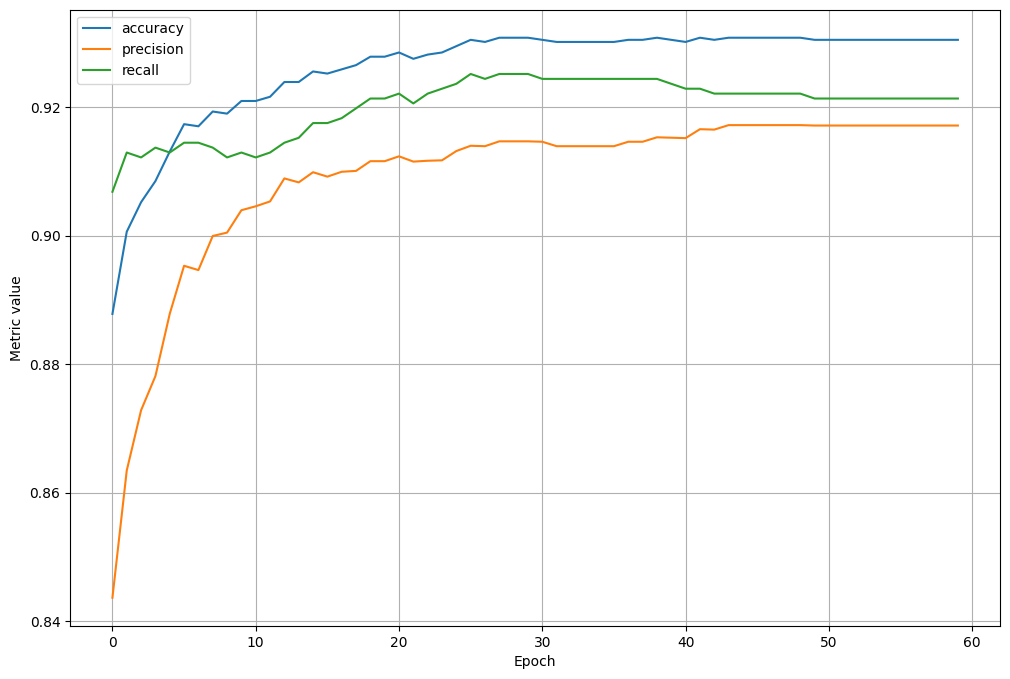

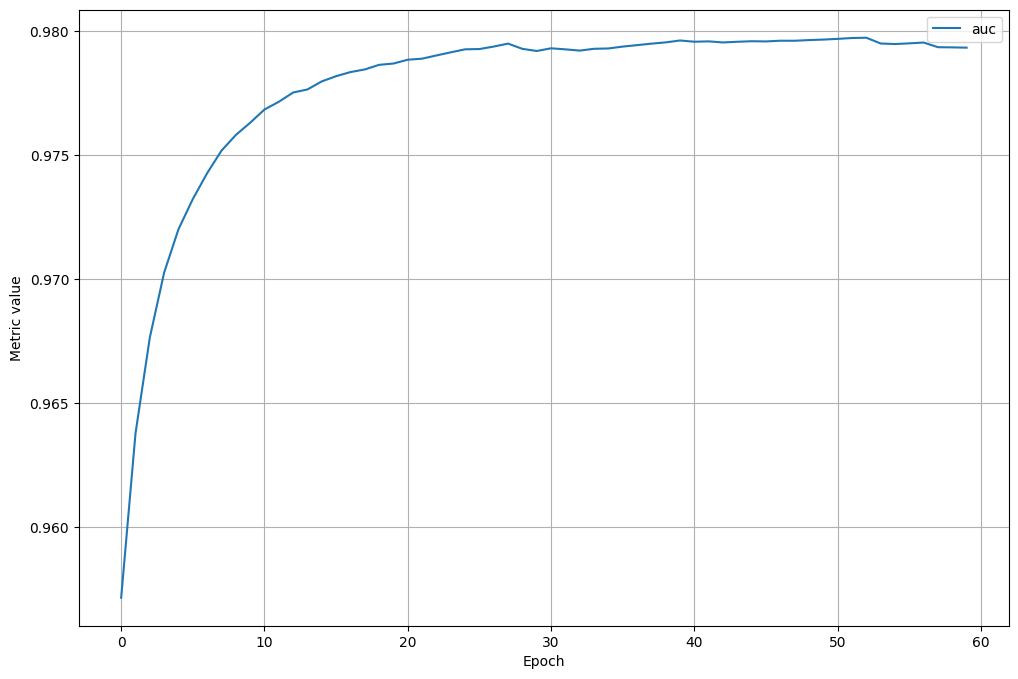

In [29]:
settings_all_features = ExperimentSettings(
    learning_rate=0.001,
    number_epochs=60,
    batch_size=100,
    classification_threshold=0.5,
    input_features=all_input_features,
)

# Modify the following definition of METRICS to generate
# not only accuracy and precision, but also recall:
metrics = [
    keras.metrics.BinaryAccuracy(
        name='accuracy',
        threshold=settings_all_features.classification_threshold,
    ),
    keras.metrics.Precision(
        name='precision',
        thresholds=settings_all_features.classification_threshold,
    ),
    keras.metrics.Recall(
        name='recall', thresholds=settings_all_features.classification_threshold
    ),
    keras.metrics.AUC(num_thresholds=100, name='auc'),
]

# Establish the model's topography.
model_all_features = create_model(settings_all_features, metrics)

# Train the model on the training set.
experiment_all_features = train_model(
    'all features',
    model_all_features,
    train_features,
    train_labels,
    settings_all_features,
)

# Plot metrics vs. epochs
plot_experiment_metrics(
    experiment_all_features, ['accuracy', 'precision', 'recall']
)
plot_experiment_metrics(experiment_all_features, ['auc'])

In [30]:
test_metrics_all_features = evaluate_experiment(
    experiment_all_features, test_features, test_labels
)
compare_train_test(experiment_all_features, test_metrics_all_features)

Comparing metrics between train and test:
------
Train accuracy: 0.9304
Test accuracy:  0.9213
------
Train auc: 0.9793
Test auc:  0.9761
------
Train loss: 0.1790
Test loss:  0.1900
------
Train precision: 0.9171
Test precision:  0.9067
------
Train recall: 0.9213
Test recall:  0.8947


In [32]:
#@title Define function to compare experiments

def compare_experiment(experiments: list[Experiment],
                       metrics_of_interest: list[str],
                       test_dataset: pd.DataFrame,
                       test_labels: np.array):
  # Make sure that we have all the data we need.
  for metric in metrics_of_interest:
    for experiment in experiments:
      if metric not in experiment.metrics_history:
        raise ValueError(f'Metric {metric} not available for experiment {experiment.name}')

  fig = plt.figure(figsize=(12, 12))
  ax = fig.add_subplot(2, 1, 1)

  colors = [f'C{i}' for i in range(len(experiments))]
  markers = ['.', '*', 'd', 's', 'p', 'x']
  marker_size = 10

  ax.set_title('Train metrics')
  for i, metric in enumerate(metrics_of_interest):
    for j, experiment in enumerate(experiments):
      plt.plot(experiment.epochs, experiment.metrics_history[metric], markevery=4,
               marker=markers[i], markersize=marker_size, color=colors[j])

  # Add custom legend to show what the colors and markers mean
  legend_handles = []
  for i, metric in enumerate(metrics_of_interest):
    legend_handles.append(Line2D([0], [0], label=metric, marker=markers[i],
                                 markersize=marker_size, c='k'))
  for i, experiment in enumerate(experiments):
    legend_handles.append(Line2D([0], [0], label=experiment.name, color=colors[i]))

  ax.set_xlabel("Epoch")
  ax.set_ylabel("Metric value")
  ax.grid()
  ax.legend(handles=legend_handles)

  ax = fig.add_subplot(2, 1, 2)
  spacing = 0.3
  n_bars = len(experiments)
  bar_width = (1 - spacing)/n_bars
  for i, experiment in enumerate(experiments):
    test_metrics = evaluate_experiment(experiment, test_dataset, test_labels)
    x = np.arange(len(metrics_of_interest)) + bar_width * (i + 1/2 - n_bars/2)
    ax.bar(x, [test_metrics[metric] for metric in metrics_of_interest], width=bar_width, label=experiment.name)
  ax.set_xticks(np.arange(len(metrics_of_interest)), metrics_of_interest)

  ax.set_title('Test metrics')
  ax.set_ylabel('Metric value')
  ax.set_axisbelow(True) # Put the grid behind the bars
  ax.grid()
  ax.legend()

print('Defined function to compare experiments.')

Defined function to compare experiments.


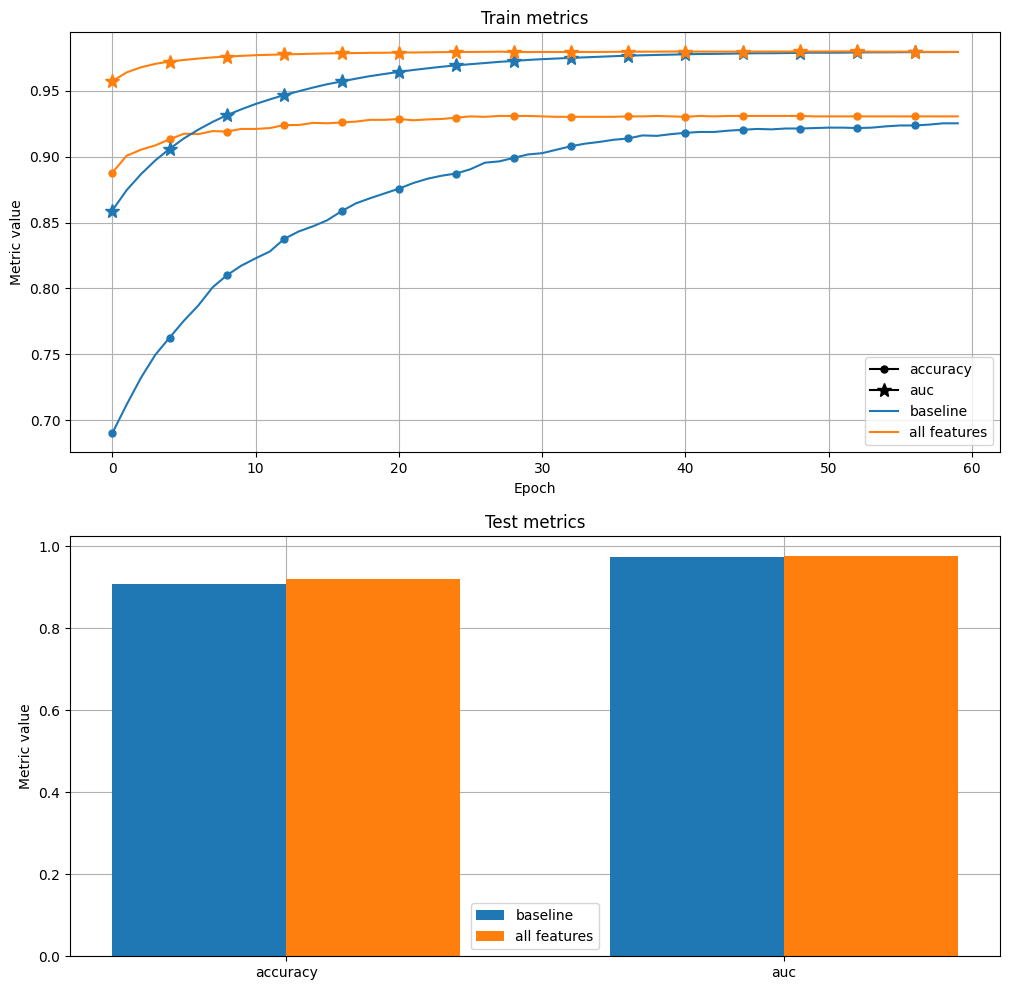

In [33]:
compare_experiment([experiment, experiment_all_features],
                   ['accuracy', 'auc'],
                   test_features, test_labels)